In [135]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 10 13:17:46 2022

@author: BetzLab-Admin
"""
from time import sleep, time
from pipython import GCSDevice
from pipython import pitools
from scipy.signal import fftconvolve
import keyboard
import numpy as np
from detection_methods import trajectory_corr, trajectory_gauss, trajectory_mean,trajectory_till, trajectory_till_stepwise,most_common_value, compare_trajectories, plt_accuracy_results, trajectory_polar_comparison,save_result, load_result
from detection_methods import make_test_trajectory as make_movie
import matplotlib.pyplot as plt
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage import label
import csv
import random
import os
from tqdm import tqdm

#from pipython.datarectools import getservotime

#core.set_exposure(0.5)##sets the cameras exposure time for snapshots to half a milisecond

In this notebook, I am going to figure out, how reliable the postition setting and the postion reading of the small stage is.


In [2]:
pidevice= GCSDevice('E-727')
STAGES=None
REFMODES=None
#core=Core()
pidevice.InterfaceSetupDlg()

pidevice.SVO('1', True)
pidevice.SVO('2', True)
pidevice.SVO('3', True)


In [3]:
def position(pidevice):
    positions = pidevice.qPOS(pidevice.axes)
    return np.array([positions['1'],positions['2']])

def move_stage(pidevice,axis,target):
    rangemin = pidevice.qTMN()
    rangemax = pidevice.qTMX()
    if target >= rangemin[str(axis)] and target <= rangemax[str(axis)]:
        pidevice.MOV(axis, target)
        pitools.waitontarget(pidevice, axes=axis)

In [68]:
def autocorrelation(data):
    """
    Compute autocorrelation of a data series.
    """
    n = len(data)
    data = data - np.mean(data)
    result = np.correlate(data, data, mode='full')
    result = result / np.max(result)  # Normalize result
    return result[int(result.size/2):]

In [83]:
granularity=1
N_position_samples=100
N_samples_per_position=1000
t_wait_sample=0#.01
set_position_list=[]
measured_trajectory_list=[]
time_list_list=[]


set_position = np.array([50, 50], dtype=float)
for _ in range(N_position_samples):
    set_position_list.append(set_position.copy())
    move_stage(pidevice, 1, set_position[0])
    move_stage(pidevice, 2, set_position[1])
    #sleep(.1)
    measured_trajectory=[]
    time_list=[]
    time_0=time()
    for _ in range(N_samples_per_position):
        measured_trajectory.append(position(pidevice))
        time_list.append(time()-time_0)
        sleep(t_wait_sample)
    time_list_list.append(time_list)
    measured_trajectory=np.stack(measured_trajectory)
    measured_trajectory_list.append(measured_trajectory)

    random_angle = 2 * np.pi * np.random.rand()  # Generates a random angle in [0, 2π]
    random_step = np.array([np.cos(random_angle),np.sin(random_angle)])*granularity
    set_position+=random_step


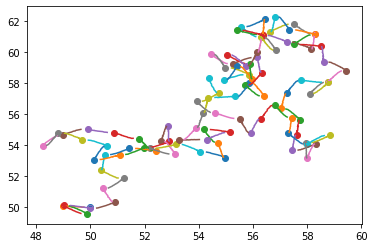

In [84]:
for set_position, time_list, measured_trajectory in zip(set_position_list,time_list_list,measured_trajectory_list):
    plt.scatter(set_position[0],set_position[1])
    plt.plot(measured_trajectory[:,0],measured_trajectory[:,1])


Text(0, 0.5, 'distance from set postion to read postion')

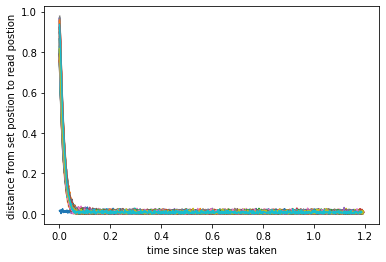

In [85]:
for set_position, time_list, measured_trajectory in zip(set_position_list,time_list_list,measured_trajectory_list):
    distances=[np.linalg.norm(measured_point-set_position) for measured_point in measured_trajectory]
    plt.plot(time_list,distances)
plt.xlabel('time since step was taken')
plt.ylabel('distance from set postion to read postion')

We see, that the measured poition differs in the beginning, but seems very lose after about .1 second.

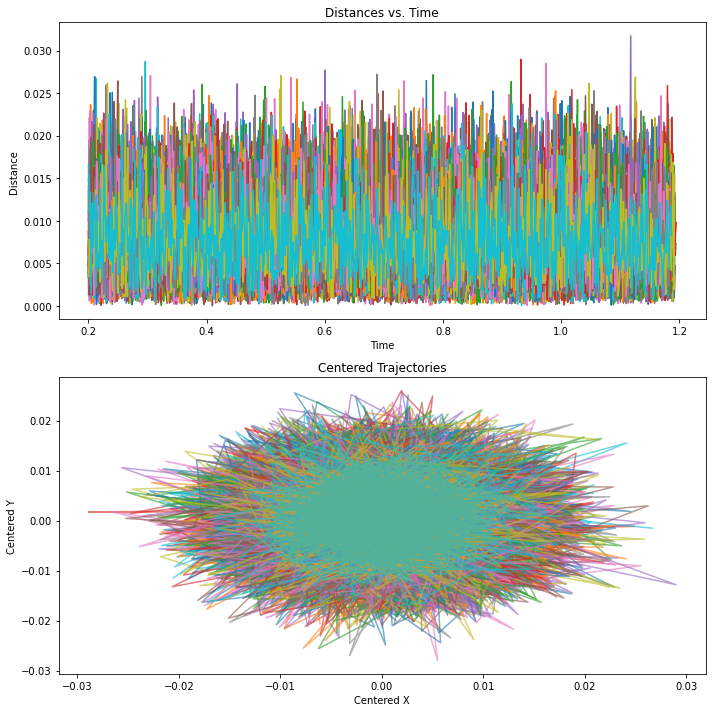

In [86]:
import numpy as np
import matplotlib.pyplot as plt

mean_distance_list = []
std_list = []
distance_of_mean_list = []
error_of_mean_list = []

# Create subplots for both graphs
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# First subplot for distances vs. time
axs[0].set_title("Distances vs. Time")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Distance")

# Second subplot for centered trajectories
axs[1].set_title("Centered Trajectories")
axs[1].set_xlabel("Centered X")
axs[1].set_ylabel("Centered Y")
cutoff_time = 0.2

autocorrelation_list_x=[]
autocorrelation_list_y=[]
filtered_times_list=[]
for set_position, time_list, measured_trajectory in zip(set_position_list, time_list_list, measured_trajectory_list):
    # Filter times and distances where time is greater than 0.1 seconds
    filtered_times = [time for time in time_list if time > cutoff_time]
    filtered_measured_trajectory = [measured_point for time, measured_point in zip(time_list, measured_trajectory) if time > cutoff_time]

    filtered_distances = [np.linalg.norm(measured_point - set_position) for measured_point in filtered_measured_trajectory]
    
    # Add data to lists
    mean_distance_list.append(np.mean(filtered_distances))
    std_list.append(np.sqrt(sum(np.var(filtered_measured_trajectory,axis=0))))
    distance_of_mean_list.append(np.linalg.norm(np.mean(filtered_measured_trajectory,axis=0) - set_position))
    error_of_mean_list.append(np.sqrt(np.sum(np.var(filtered_measured_trajectory,axis=0) / len(filtered_measured_trajectory))))

    

    # Plot data on the subplots
    axs[0].plot(filtered_times, filtered_distances)

    centered_trajectory = filtered_measured_trajectory - set_position
    autocorrelation_list_x.append(autocorrelation(centered_trajectory[:,0]))
    autocorrelation_list_y.append(autocorrelation(centered_trajectory[:,1]))
    filtered_times_list.append(filtered_times)
    axs[1].plot(centered_trajectory[:, 0], centered_trajectory[:, 1], alpha=0.6)
    axs[1].scatter(np.mean(centered_trajectory,axis=0)[0], np.mean(centered_trajectory,axis=0)[1])

plt.tight_layout()  # Adjust layout for better visualization
plt.show()


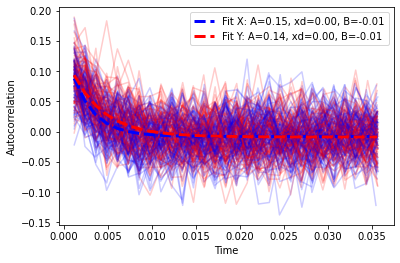

Fitted for X: A = 0.1544, xd = 0.0025, B = -0.0080
Fitted for Y: A = 0.1415, xd = 0.0036, B = -0.0088


In [133]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def modified_exponential(x, A, xd, B):
    """Modified Exponential function."""
    return A * np.exp(-x / xd) + B

N_position_samples = 30
pooled_autocorr_x = []
pooled_autocorr_y = []
pooled_times = []

dt_list = []
for filtered_times, autocorrelation_x, autocorrelation_y in zip(filtered_times_list, autocorrelation_list_x, autocorrelation_list_y):
    dt = (max(filtered_times) - min(filtered_times)) / len(filtered_times)
    times = np.linspace(dt, dt * N_position_samples, N_position_samples - 1)
    pooled_times.extend(times)
    dt_list.append(dt)
    
    pooled_autocorr_x.extend(autocorrelation_x[1:N_position_samples])
    pooled_autocorr_y.extend(autocorrelation_y[1:N_position_samples])
    
    # Plot each trajectory
    plt.plot(times, autocorrelation_x[1:N_position_samples], 'b-', alpha=0.2)
    plt.plot(times, autocorrelation_y[1:N_position_samples], 'r-', alpha=0.2)

avg_dt = np.mean(dt_list)
times = np.linspace(avg_dt, avg_dt * N_position_samples, N_position_samples - 1)

# Fit pooled data
initial_guess = [1, 0.005, 0]
params_x, _ = curve_fit(modified_exponential, pooled_times, pooled_autocorr_x, p0=initial_guess)
params_y, _ = curve_fit(modified_exponential, pooled_times, pooled_autocorr_y, p0=initial_guess)

# Plot the fitted exponential
plt.plot(times, modified_exponential(times, *params_x), 'b--', label=f'Fit X: A={params_x[0]:.2f}, xd={params_x[1]:.2f}, B={params_x[2]:.2f}', linewidth=3)
plt.plot(times, modified_exponential(times, *params_y), 'r--', label=f'Fit Y: A={params_y[0]:.2f}, xd={params_y[1]:.2f}, B={params_y[2]:.2f}', linewidth=3)

plt.xlabel('Time')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

# Print out the fitted parameters
print(f"Fitted for X: A = {params_x[0]:.4f}, xd = {params_x[1]:.4f}, B = {params_x[2]:.4f}")
print(f"Fitted for Y: A = {params_y[0]:.4f}, xd = {params_y[1]:.4f}, B = {params_y[2]:.4f}")


We further see, that the difference between read and set position has an autocorrelation of about 0.0025. 
So by setting the position to something, waiting for .1 second, and then remeasuring the position everz 0.01 seconds, we should get biased uindependent measuremnets of the read position

In [145]:
granularity=1
N_position_samples=50
N_samples_per_position=400
t_wait_sample=.01
set_position_list=[]
measured_trajectory_list=[]
time_list_list=[]


set_position = np.array([50, 50], dtype=float)
for _ in tqdm(range(N_position_samples)):
    set_position_list.append(set_position.copy())
    move_stage(pidevice, 1, set_position[0])
    move_stage(pidevice, 2, set_position[1])
    sleep(.1)
    measured_trajectory=[]
    time_list=[]
    time_0=time()
    for _ in range(N_samples_per_position):
        measured_trajectory.append(position(pidevice))
        time_list.append(time()-time_0)
        sleep(t_wait_sample)
    time_list_list.append(time_list)
    measured_trajectory=np.stack(measured_trajectory)
    measured_trajectory_list.append(measured_trajectory)

    random_angle = 2 * np.pi * np.random.rand()  # Generates a random angle in [0, 2π]
    random_step = np.array([np.cos(random_angle),np.sin(random_angle)])*granularity
    set_position+=random_step


100%|██████████| 50/50 [05:21<00:00,  6.42s/it]


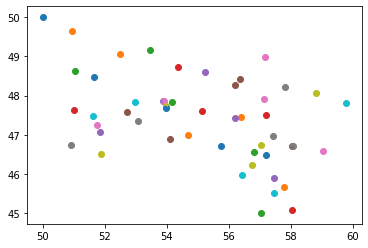

In [146]:
for set_position, time_list, measured_trajectory in zip(set_position_list,time_list_list,measured_trajectory_list):
    plt.scatter(set_position[0],set_position[1])
    plt.plot(measured_trajectory[:,0],measured_trajectory[:,1])


Text(0, 0.5, 'distance from set postion to read postion')

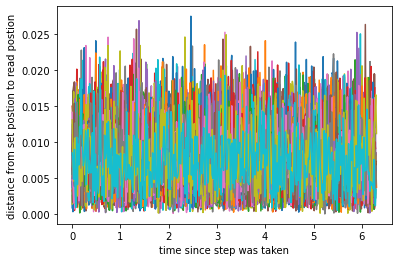

In [147]:
for set_position, time_list, measured_trajectory in zip(set_position_list,time_list_list,measured_trajectory_list):
    distances=[np.linalg.norm(measured_point-set_position) for measured_point in measured_trajectory]
    plt.plot(time_list,distances)
plt.xlabel('time since step was taken')
plt.ylabel('distance from set postion to read postion')

In [148]:
import numpy as np
import matplotlib.pyplot as plt

max_sample_number = 100
N_position_samples = 100

sample_number_list = np.linspace(1, max_sample_number, max_sample_number, dtype=int)

error_list_dict = {}
deviation_list_dict = {}

for sample_number in sample_number_list:
    error_list=[]
    deviation_list=[]
    for set_position, time_list, measured_trajectory in zip(set_position_list, time_list_list, measured_trajectory_list):
        sampled_measured_trajectory = measured_trajectory[:sample_number]
        deviation_list.append(np.linalg.norm(np.mean(sampled_measured_trajectory,axis=0) - set_position))
        error_list.append(np.sqrt(np.sum(np.var(sampled_measured_trajectory,axis=0) / len(sampled_measured_trajectory))))
    error_list_dict[sample_number] = error_list
    deviation_list_dict[sample_number] = deviation_list

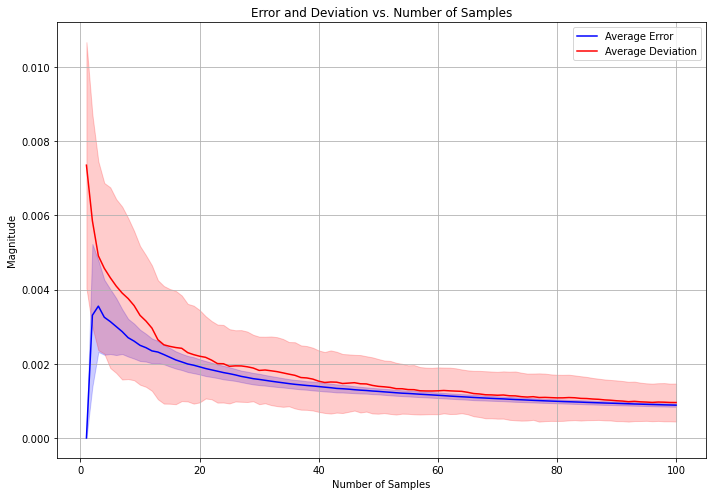

In [149]:
import numpy as np
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 7))

# Calculate the average and standard deviation of error and deviation across the trajectories for each sample number
avg_errors = [np.mean(error_list_dict[key]) for key in sample_number_list]
std_errors = [np.std(error_list_dict[key]) for key in sample_number_list]
avg_deviations = [np.mean(deviation_list_dict[key]) for key in sample_number_list]
std_deviations = [np.std(deviation_list_dict[key]) for key in sample_number_list]

# Plot the average values
plt.plot(sample_number_list, avg_errors, color="blue", label="Average Error")
plt.plot(sample_number_list, avg_deviations, color="red", label="Average Deviation")

# Shade the region between the average plus/minus one standard deviation
plt.fill_between(sample_number_list, np.array(avg_errors) - np.array(std_errors), np.array(avg_errors) + np.array(std_errors), color="blue", alpha=0.2)
plt.fill_between(sample_number_list, np.array(avg_deviations) - np.array(std_deviations), np.array(avg_deviations) + np.array(std_deviations), color="red", alpha=0.2)

# Set plot labels and title
plt.xlabel("Number of Samples")
plt.ylabel("Magnitude")
plt.title("Error and Deviation vs. Number of Samples")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


We can see, that the error and the deviation track each other, though the error consitantly undersetimates the deviation. 
Notably: we do not see the error and deviation decouple, with the error going to 0 and the deviation approximating some finite value. This means, that although the measurements still seem to be somewhat correlated (as to be expected, kinda, because the autorrelation goes exponentially to 0 but never reaches it), the read values of the stage postion are measurements of the set position plus gaussian noise, that can be arbitrarily minimized, by taking more datapoints
